In [173]:
# coding: utf-8
import numpy as np
import scipy.constants as sciconsts
import scipy.fftpack as fft
import scipy.interpolate as sci_interpolate
import scipy.integrate as sci_integrate
import time
import sys
from multiprocessing import Process,Pool
import scipy.optimize as sciop
import numpy as np
import scipy.constants as sciconsts
import scipy.fftpack as fft
import scipy.interpolate as sci_interpolate
import matplotlib.pyplot as plt
import scipy.integrate as sci_integrate
import time
import sys
import seaborn as sns
import os  
import matplotlib  
import matplotlib.cm as cm   
from matplotlib.ticker import MultipleLocator  
from mpl_toolkits.mplot3d import Axes3D
from scipy.misc import derivative

In [174]:
'''parameters'''
def chirp_mass(m1,m2):
    return np.power(m1*m2,0.6)/(np.power(m1+m2,0.2))
def solvem(mc,smr):
    a=mc/np.power(smr,0.6)
    b=smr*np.power(a,2.0)
    m1=(a+np.sqrt(np.power(a,2.0)-4.0*b))/2.0
    m2=(a-np.sqrt(np.power(a,2.0)-4.0*b))/2.0
    return np.array((m1,m2))
def sym_mass_ratio(m1,m2):
    return m1*m2/(np.power(m1+m2,2.0))
'''lisa noise curve in rpsd unit N2A5:laserpower 2w,40cm telescope,armlength 5e6 km'''
def S_gal_N2A5(f):
    if f>=1.0e-5 and f<1.0e-3:
        return np.power(f,-2.3)*np.power(10,-44.62)*20.0/3.0
    if f>=1.0e-3 and f<np.power(10,-2.7):
        return np.power(f,-4.4)*np.power(10,-50.92)*20.0/3.0
    if f>=np.power(10,-2.7) and f<np.power(10,-2.4):
        return np.power(f,-8.8)*np.power(10,-62.8)*20.0/3.0
    if f>=np.power(10,-2.4) and f<=0.01:
        return np.power(f,-20.0)*np.power(10,-89.68)*20.0/3.0
    if f>0.01 or f<1.0e-5:
        return 0
def S_n_lisa(f):
    m1=5.0e9
    m2=sciconsts.c*0.41/m1/2.0
    return 20.0/3.0*(1+np.power(f/m2,2.0))*(4.0*(9.0e-30/np.power(2*sciconsts.pi*f,4.0)*(1+1.0e-4/f))+2.96e-23+2.65e-23)/np.power(m1,2.0)+S_gal_N2A5(f)



In [175]:
'''vac model from cutler94'''


def phi(f,m1,m2,phic,tc):
    x=np.power(sciconsts.pi*(m1+m2)*f,2.0/3.0)
    mc=chirp_mass(m1,m2)
    a=0.75*np.power(8*sciconsts.pi*mc*f,-5.0/3.0)*(1+20.0/9.0*(743.0/336.0+11.0*m1*m2/(m1+m2)/(m1+m2)/4.0)*x-16.0*sciconsts.pi*np.power(x,1.5))
    return a-phic+2*sciconsts.pi*f*tc-0.25*sciconsts.pi

def hf(f,m1,m2,d,phic):
    mc=chirp_mass(m1,m2)
    phi=phi(f,m1,m2,phic)
    return mc/d*np.power(f,-7.0/6.0)*np.exp(1.0j*1.0)


In [176]:
'''my T model(considering gas (geo unit)'''
def k_1cal(m_1,m_2):
    return 64.0*m_1*m_2*(m_1+m_2)/5.0
def t_0cal(m_1,m_2,t_gas,a_0):
    return t_gas*0.25*np.log(k_1cal(m_1,m_2)*t_gas+np.power(a_0,4.0))
def acalgas(t,k_1,t_gas,t_0):
    return np.power((np.exp(4.0*(t_0-t)/t_gas)-k_1*t_gas),0.25)
def freq_tgas(t,m_1,m_2,t_gas,t_0):
    k_1=k_1cal(m_1,m_2)
    a_ft=acalgas(t,k_1,t_gas,t_0)
    return 1.0/sciconsts.pi*np.sqrt((m_1+m_2))*np.power(a_ft,-1.5)
def phi_tgas(t,m_1,m_2,t_gas,t_0):
    return sci_integrate.quad(lambda x:2*sciconsts.pi*freq_tgas(x,m_1,m_2,t_gas,t_0),0,t)[0]
def hgas(t,m_1,m_2,t_gas,t_0,phi):
    k_1=k_1cal(m_1,m_2)
    return m_1*m_2/acalgas(t,k_1,t_gas,t_0)*np.cos(phi)

In [205]:
'''f model gas '''
def df_dtgas(f,m1,m2,tgas):
    mu=m1*m2/(m1+m2)
    M=m1+m2
    mc=chirp_mass(m1,m2)
    x=sciconsts.pi*f/np.sqrt(M)
    return 1.5/tgas*f+96.0/5*np.power(sciconsts.pi,8.0/3)*np.power(mc,5.0/3.0)*np.power(f,11.0/3)

def hgas_amp(f,m1,m2,tgas):
    mu1=m1*m2/(m1+m2)
    M1=m1+m2
    return mu1*M1*np.power(sciconsts.pi*f/np.sqrt(M1),2.0/3.0)/np.power(df_dtgas(f,m1,m2,tgas),0.5)/2.0

def f_to_t(f,m1,m2,tc,tgas):
    x=sciconsts.pi*f/np.sqrt(m1+m2)
    return tc-0.25*tgas*np.log(np.power(x,-8.0/3)+tgas*64.0/5*m1*m2*(m1+m2))

In [215]:
#consts setting
#c=G=1 unit [s]
sivalue=1
m_sun=1.9891e30*sciconsts.G/np.power(sciconsts.c,3.0)
years=365*24*3600.0
pc=3.261*sciconsts.light_year
t_scale=4*years*sivalue
#gas cal
m_cg=chirp_mass(10*m_sun,10*m_sun)
m_1g=solvem(m_cg,0.24221453287197228)[0]
m_2g=solvem(m_cg,0.24221453287197228)[1]
'''mass ratio=0.7 smr=0.24221453287197228'''
k_1g=k_1cal(m_1g,m_2g)
t_gas=1000.0*years
a_0=3.0e8/sciconsts.c
t_0g=t_0cal(m_1g,m_2g,t_gas,a_0)

# In[38]:

#(t_scale*0.01*4,N/0.01/t_scale,t_scale) 
figas=freq_tgas(0,m_1g,m_2g,t_gas,t_0g)
ffgas=freq_tgas(t_scale,m_1g,m_2g,t_gas,t_0g)
Ng=int(10000000*sivalue)
t=np.linspace(0,t_scale,num=Ng)
#tdomain interp1d
n1=10000
tphi=np.linspace(0,t_scale,n1)
i=0
workphi=np.zeros(n1)
while i<n1:
    workphi[i]=phi_tgas(tphi[i],m_1g,m_2g,t_gas,t_0g)
    i=i+1
phimo=sci_interpolate.interp1d(tphi,workphi)

In [216]:
def phivac(f,m1,m2,tgas,tc):
    t1=f_to_t(f,m1,m2,tc,tgas)
    return 2*sciconsts.pi*(t1)-0.25*sciconsts.pi-phimo(t1)


In [217]:
A=sci_integrate.quad(lambda x:4*np.power(hgas_amp(x,m_1g,m_2g,t_gas),2.0)/S_n_lisa(x),figas,ffgas,limit=1500,epsabs=0.0005)
Aval=np.sqrt(A[0])
Aerr=0.5/Aval*A[1]
Aval,Aerr

(2066594892996035.5, 11.471906163884801)

In [230]:
AB=sci_integrate.quad(lambda x:4*hgas_amp(x,m_1g,m_2g,t_gas)*hs(x)/S_n_lisa(x)*np.cos(phivac(x,m_1g,m_2g,t_gas,t_0g)-anglegas(x)+sciconsts.pi),figas,ffgas,limit=2500,epsrel=0.005)

In [231]:
AB[0]/Aval/A1val

0.0039378104183747436

In [218]:
#consts setting
#c=G=1 unit [s]
sivalue=1
m_sun=1.9891e30*sciconsts.G/np.power(sciconsts.c,3.0)
years=365*24*3600.0
pc=3.261*sciconsts.light_year
t_scale=4*years*sivalue
#gas cal
m_cg=chirp_mass(10*m_sun,10*m_sun)
m_1g=solvem(m_cg,0.24221453287197228)[0]
m_2g=solvem(m_cg,0.24221453287197228)[1]
'''mass ratio=0.7 smr=0.24221453287197228'''
k_1g=k_1cal(m_1g,m_2g)
t_gas=1000.0*years
a_0=3.0e8/sciconsts.c
t_0g=t_0cal(m_1g,m_2g,t_gas,a_0)

# In[38]:

#(t_scale*0.01*4,N/0.01/t_scale,t_scale) 
figas=freq_tgas(0,m_1g,m_2g,t_gas,t_0g)
ffgas=freq_tgas(t_scale,m_1g,m_2g,t_gas,t_0g)
Ng=int(10000000*sivalue)
t=np.linspace(0,t_scale,num=Ng)
#tdomain interp1d
n1=10000
tphi=np.linspace(0,t_scale,n1)
i=0
workphi=np.zeros(n1)
while i<n1:
    workphi[i]=phi_tgas(tphi[i],m_1g,m_2g,t_gas,t_0g)
    i=i+1
phimo=sci_interpolate.interp1d(tphi,workphi)
#tdomain point cal
Tg=t_scale/Ng
hfgas=hgas(t,m_1g,m_2g,t_gas,t_0g,phimo(t))
#fft
xs=np.linspace(0,1/2.0/Tg,num=Ng//2)
hfgas1=fft.fft(hfgas)
hfgas_abs=abs(hfgas1)
hfgas_angle=np.arctan(hfgas1.imag/hfgas1.real)[0:Ng//2]
hfgas2=2.0/Ng*hfgas_abs[0:Ng//2]
hs=sci_interpolate.interp1d(xs,hfgas2)
anglegas=sci_interpolate.interp1d(xs,hfgas_angle)


# In[76]:

A1=sci_integrate.quad(lambda x:4*np.power(hs(x),2.0)/S_n_lisa(x),figas,ffgas,limit=1500,epsabs=0.0005)
A1val=np.sqrt(A1[0])
A1err=0.5/A1val*A1[1]
A1val,A1err

(32693910.793804698, 72264.488716036387)

In [193]:
hfg2=hgas_amp(xs,m1,m2,t_gas)

/Users/shyn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in divide
  if sys.path[0] == '':


In [194]:
f=np.linspace(1e-4,1e-2,10000)


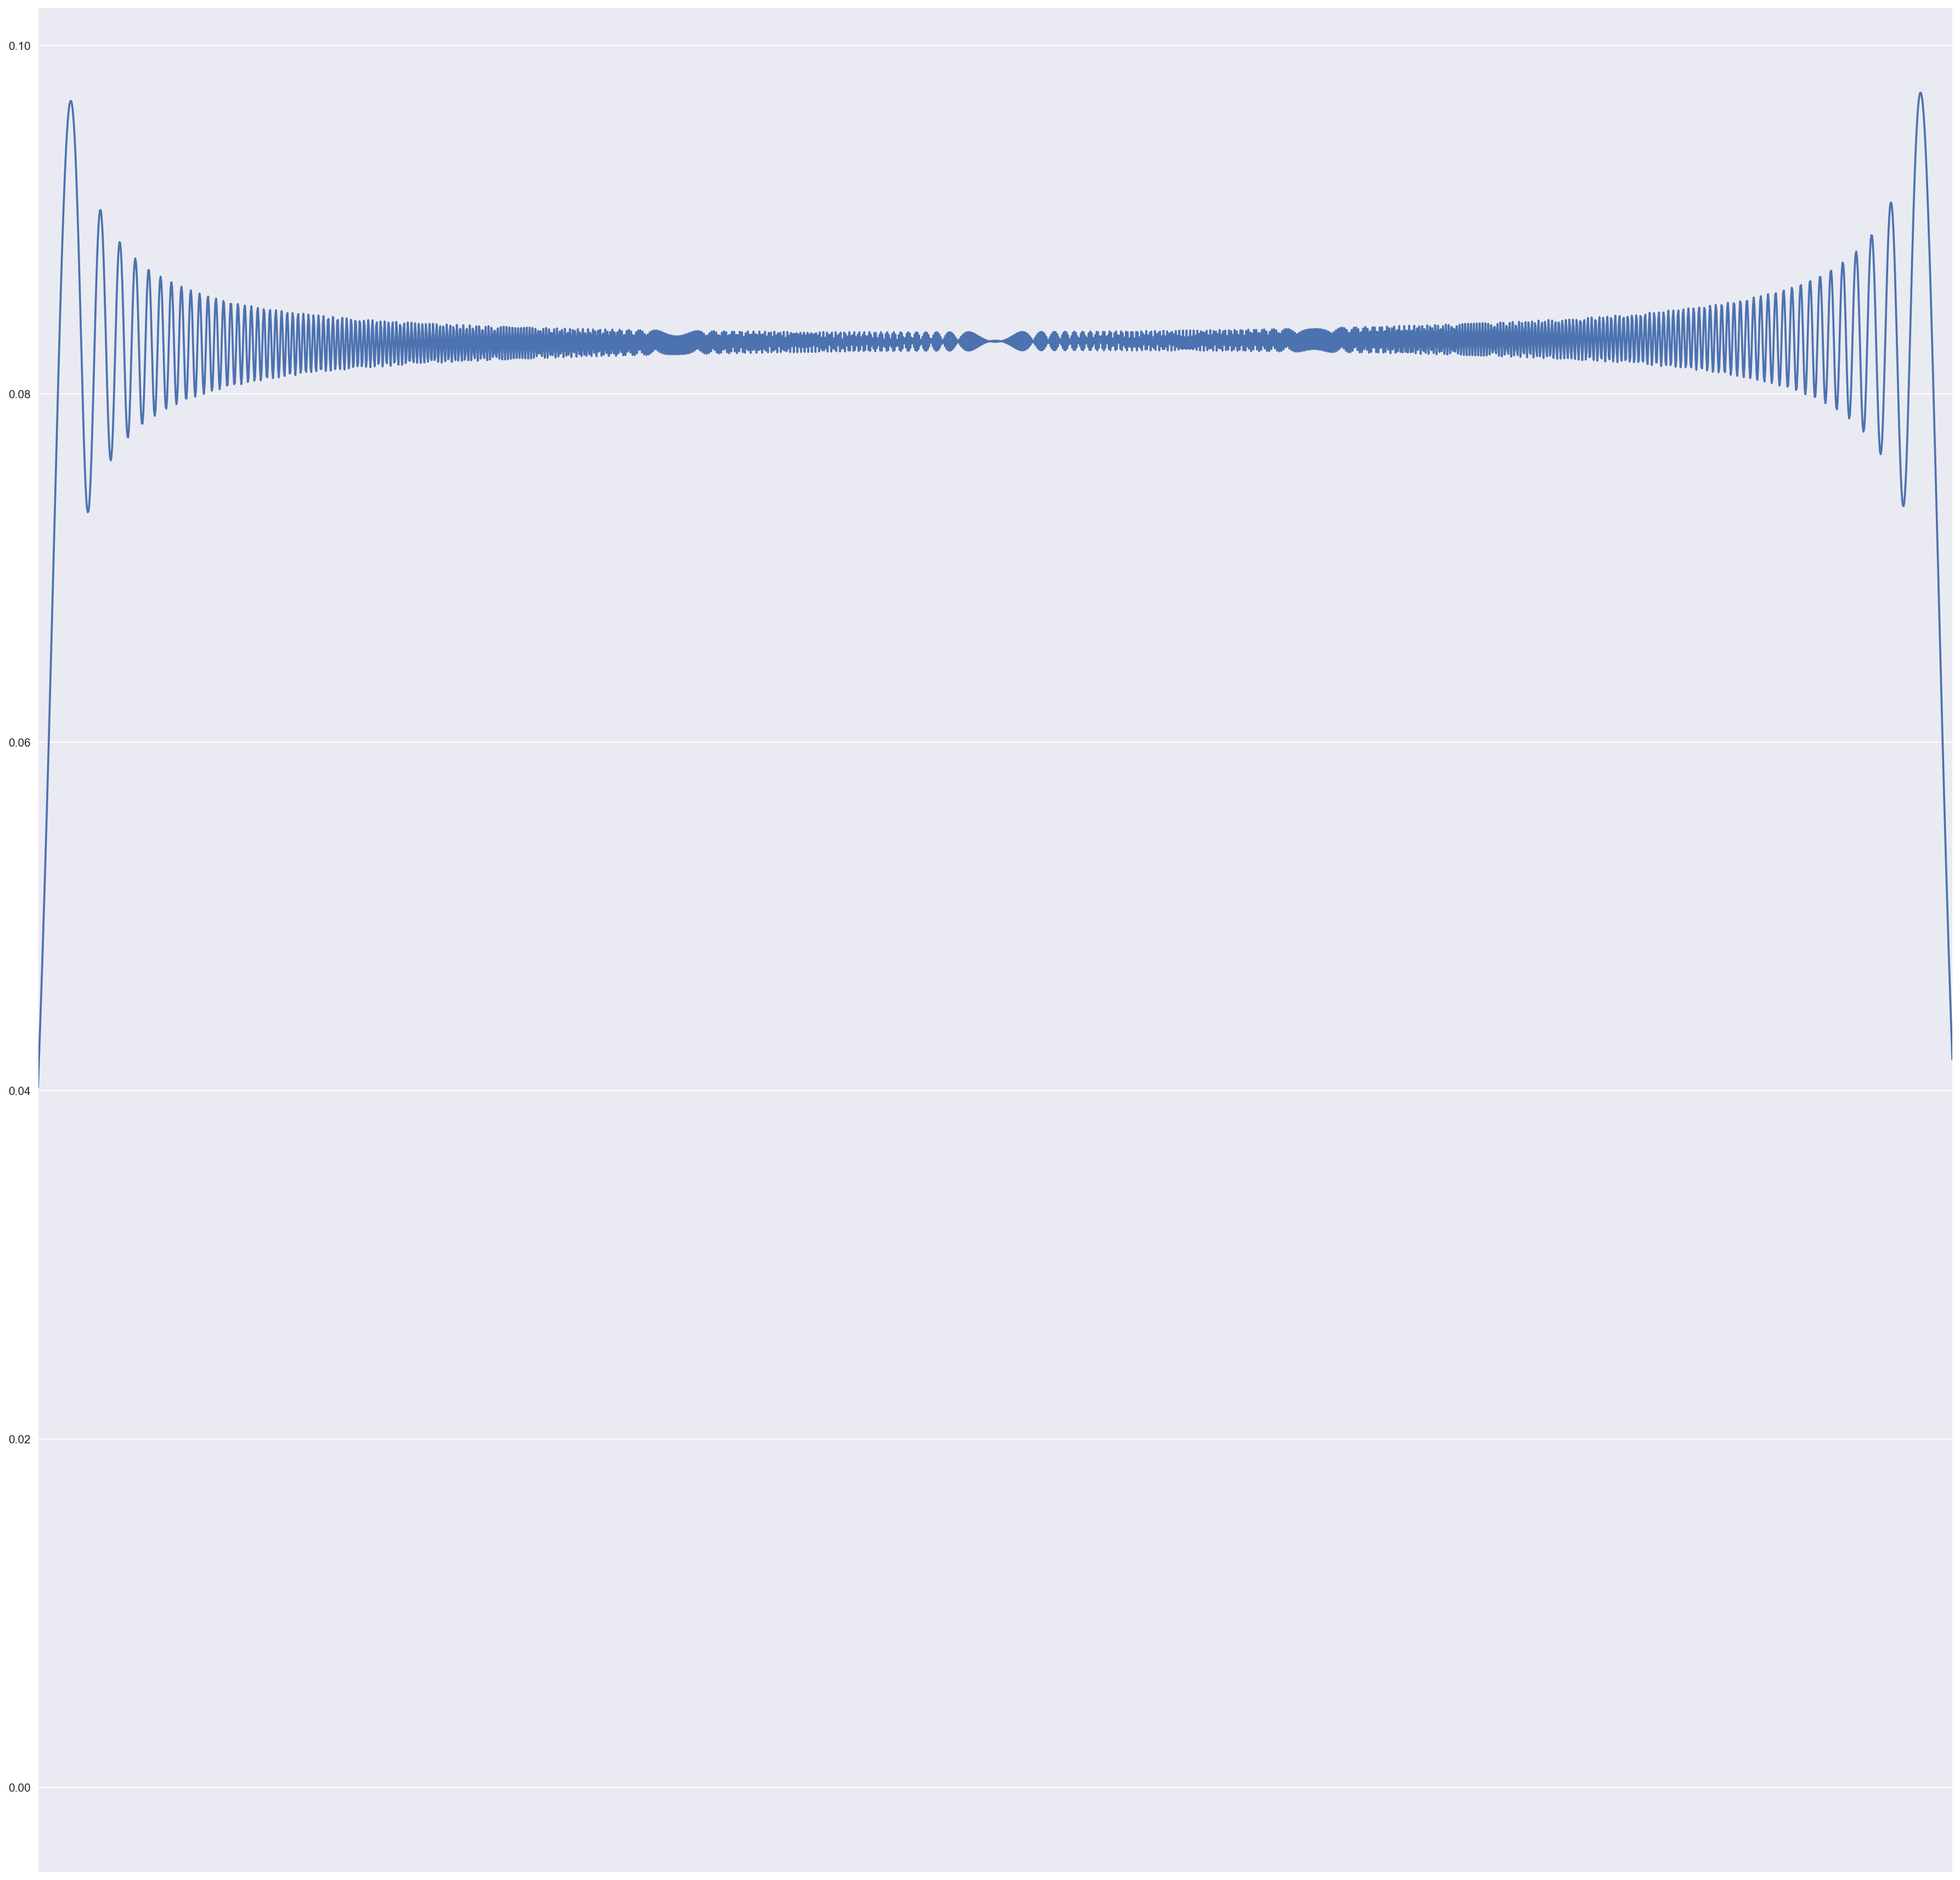

In [198]:
fig1=plt.figure(figsize=(30,30),dpi=150)
plt.xticks(fontsize=18)
#plt.yticks(fontsize=18)
#plt.plot(xs,hfgas2*t_scale/2.0,color='red')
#plt.plot(xs,hfg2,color='red')
plt.plot(xs,hfgas2*t_scale/2.0/hfg2)
#plt.vlines(figas,0,1,colors='red')
#plt.vlines(ffgas,0,1,colors='blue')
plt.xlim(figas,ffgas)
plt.xscale('log')
#plt.yscale('log')
plt.show()

In [163]:
hfgas2*t_scale/2.0/hfg2.()

array([             nan,   3.29305691e-05,   2.97950230e-05, ...,
         4.31679233e-06,   4.31679314e-06,   4.31679174e-06])

In [51]:
hfgas2*t_scale/2/

1.3883138149909442

In [116]:
Ng=int(10000000*sivalue)
t=np.linspace(0,t_scale,num=Ng)
def phivac(t,m1,m2,tc):
    mc=chirp_mass(m1,m2)
    return -2*np.power(0.2/mc*(tc-t),5.0/8.0)
def rvac(t,m1,m2,tc):
    return np.power(256.0/5*m1*m2*(m1+m2)*(tc-t),0.25)
def h(t,m1,m2,tc):
    return np.sqrt(384/5)*np.power(sciconsts.pi,2.0/3.0)/rvac(t,m1,m2,tc)*np.cos(phivac(t,m1,m2,tc))*m1*m2

def fvac(t,m1,m2,tc):
    omega=np.sqrt(m1+m2)/np.power(rvac(t,m1,m2,tc),1.5)
    return omega/sciconsts.pi

In [127]:
tc=1000*years
m1=60.0*m_sun
m2=60.0*m_sun
a=h(t,m1,m2,tc)
Tg=t_scale/Ng
xs=np.linspace(0,1/2.0/Tg,num=Ng//2)
hfvac1=fft.fft(a)
hfvac_abs=abs(hfvac1)
hfvac_angle=np.arctan(hfvac1.imag/hfvac1.real)[0:Ng//2]
hfvac2=2.0/Ng*hfvac_abs[0:Ng//2]
hs=sci_interpolate.interp1d(xs,hfvac2)
anglegas=sci_interpolate.interp1d(xs,hfvac_angle)
fmin=fvac(0,m1,m2,tc)
fmax=fvac(t_scale,m1,m2,tc)

In [128]:
fmax,fmin

(0.0014753402212290363, 0.0014731244386249297)

In [129]:
def hfvac(f,m1,m2):
    mc=chirp_mass(m1,m2)
    return np.power(mc,5.0/6.0)*np.power(f,-7.0/6.0)

/Users/shyn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/shyn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in divide
  


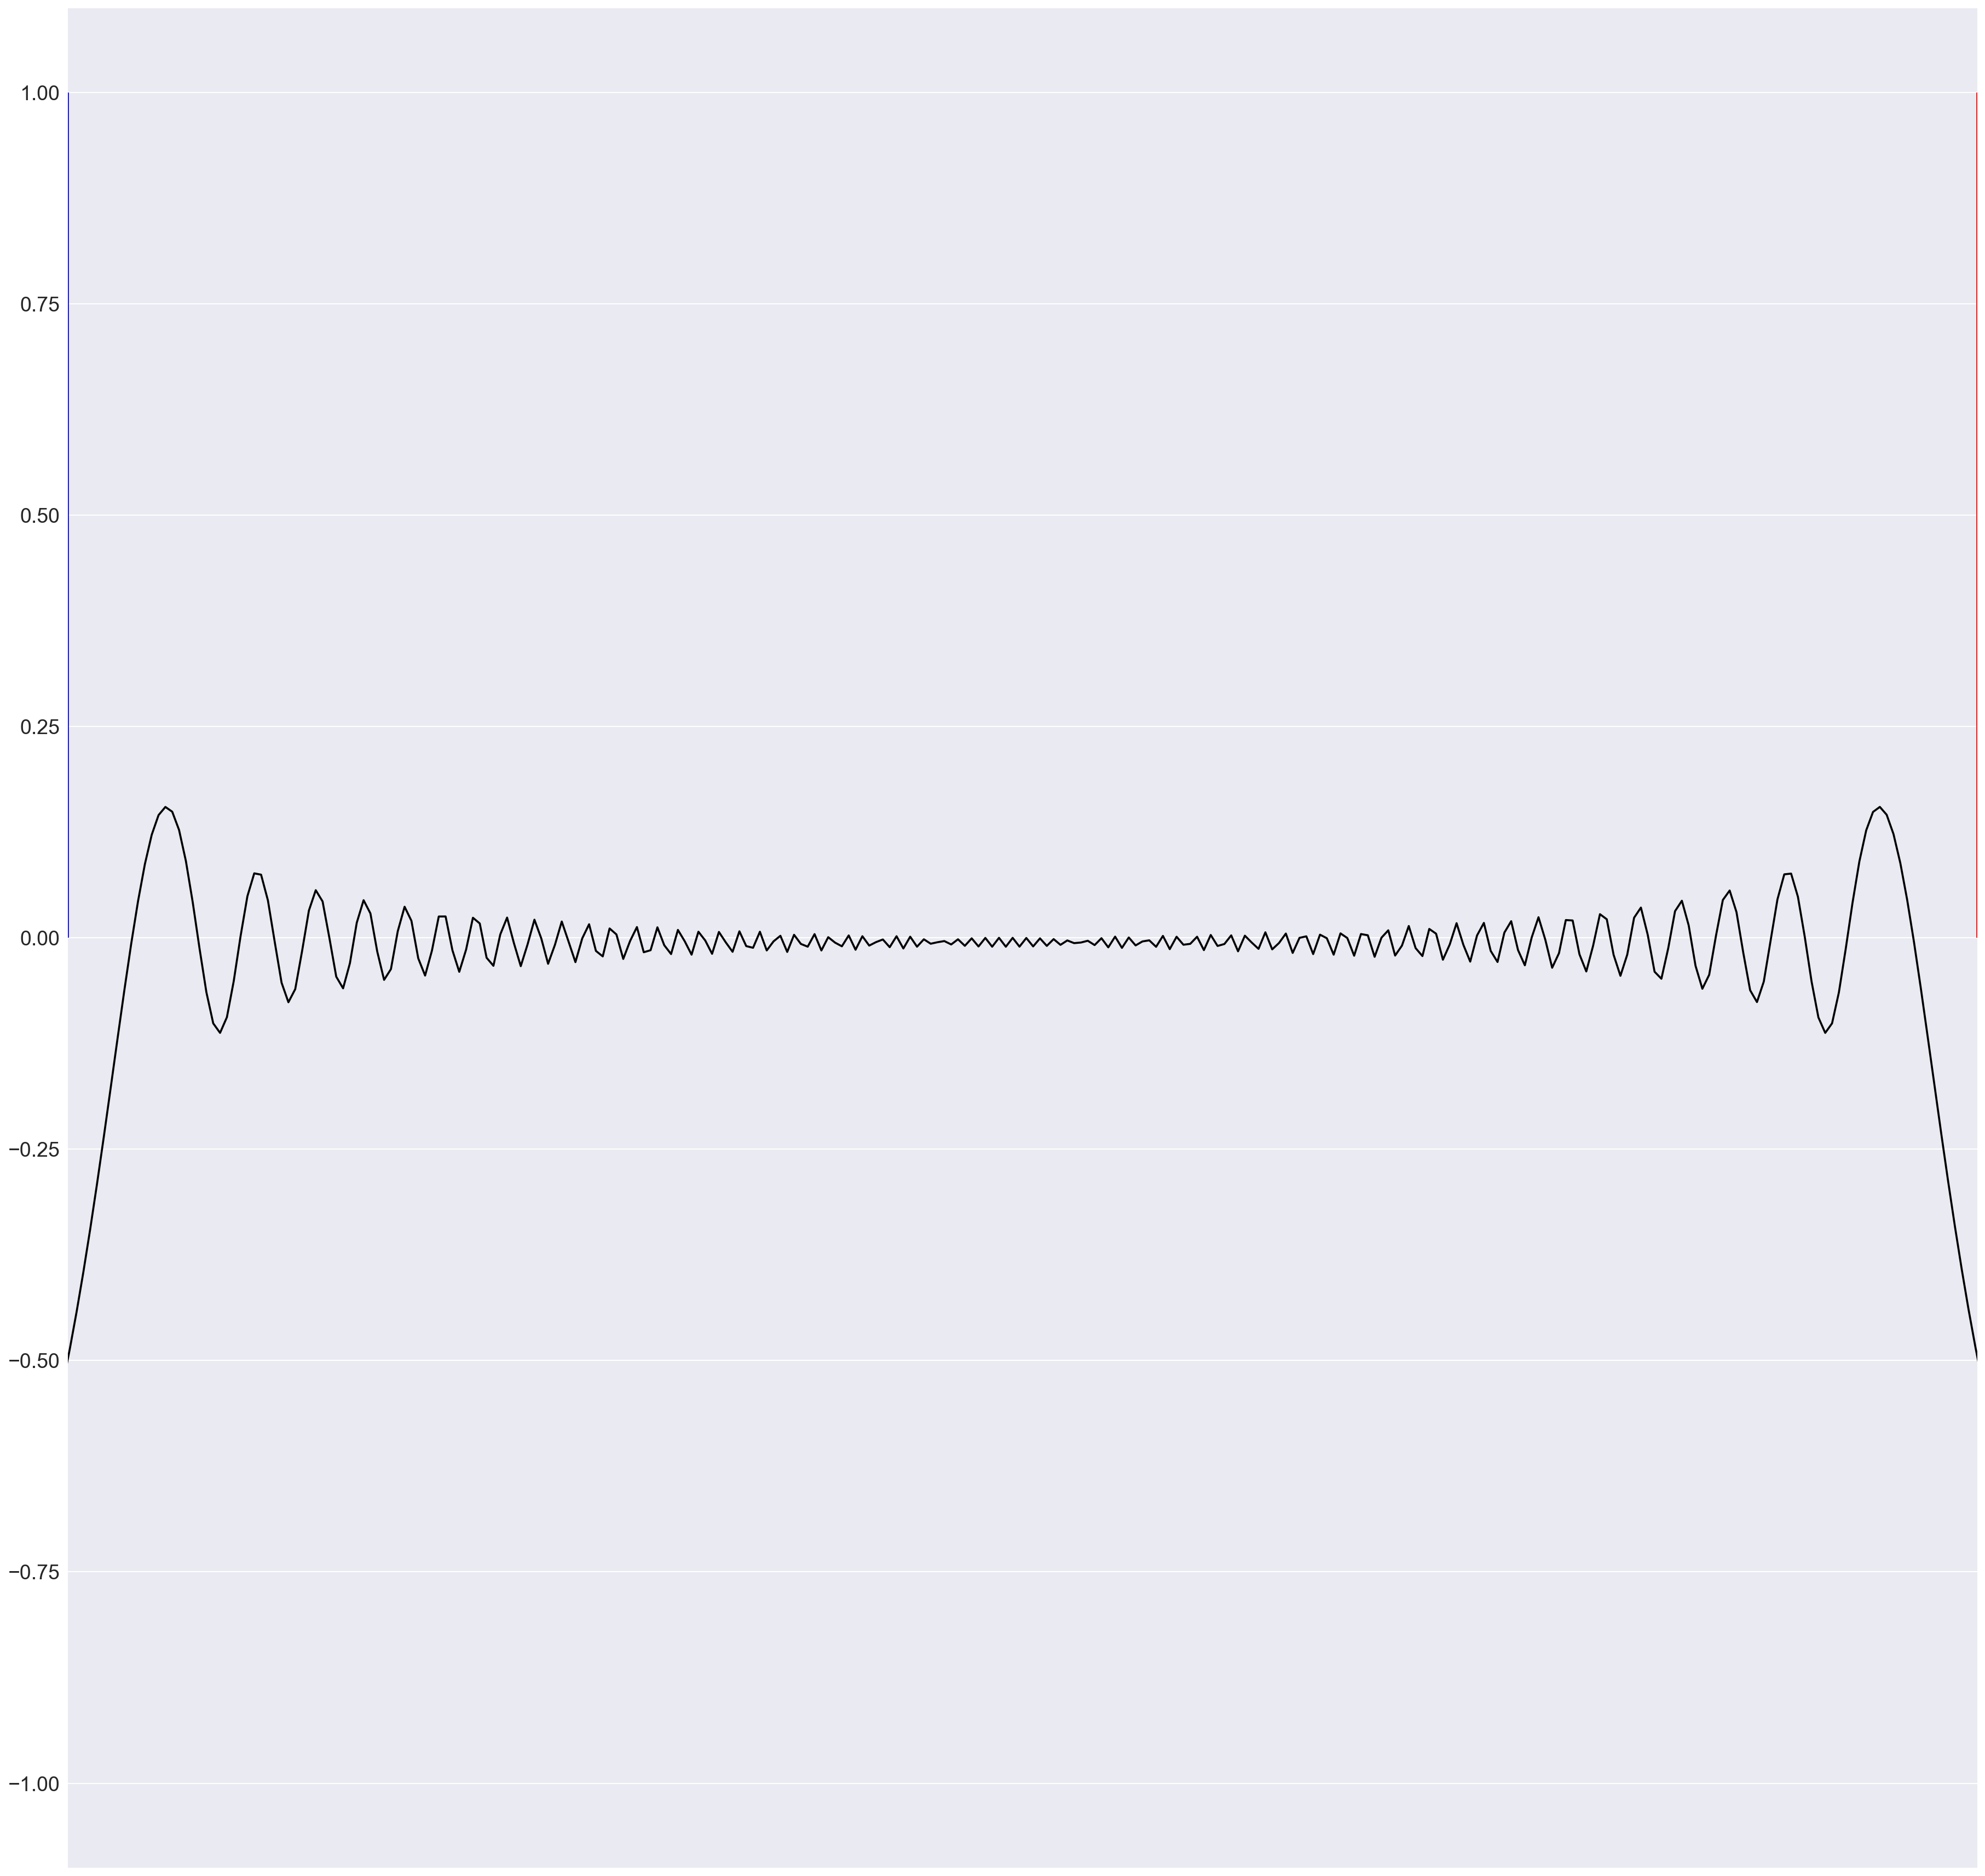

In [189]:
c=hfvac(xs,m1,m2)
fig1=plt.figure(figsize=(30,30),dpi=150)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.plot(xs,hfvac2*t_scale/2,color='black')
#plt.plot(xs,hfvac(xs,m1,m2))
#plt.plot(xs,hfvac2/hfvac(xs,m1,m2)*t_scale/2)
plt.plot(xs,(hfvac2*t_scale/2-c)/c,color='black')
plt.xlim(fmin,fmax)
lim1=[plt.axis()[2],plt.axis()[3]]
plt.vlines(fmin,0,1,colors='blue')
plt.vlines(fmax,0,1,colors='red')

plt.xscale('log')
#plt.yscale('log')
plt.show()

In [65]:
hfvac

0.33487750187997317

In [121]:
def t1(f):
    return 256/5*f
def t2(f):
    return 256.0/5*f

 t1(1.5)

In [123]:
t1(1.5),t2(1.5)

(76.5, 76.80000000000001)

51

In [133]:
a=hfvac2/hfvac(xs,m1,m2)

/Users/shyn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


In [139]:
a.max()*t_scale/2

1.1548970237348615

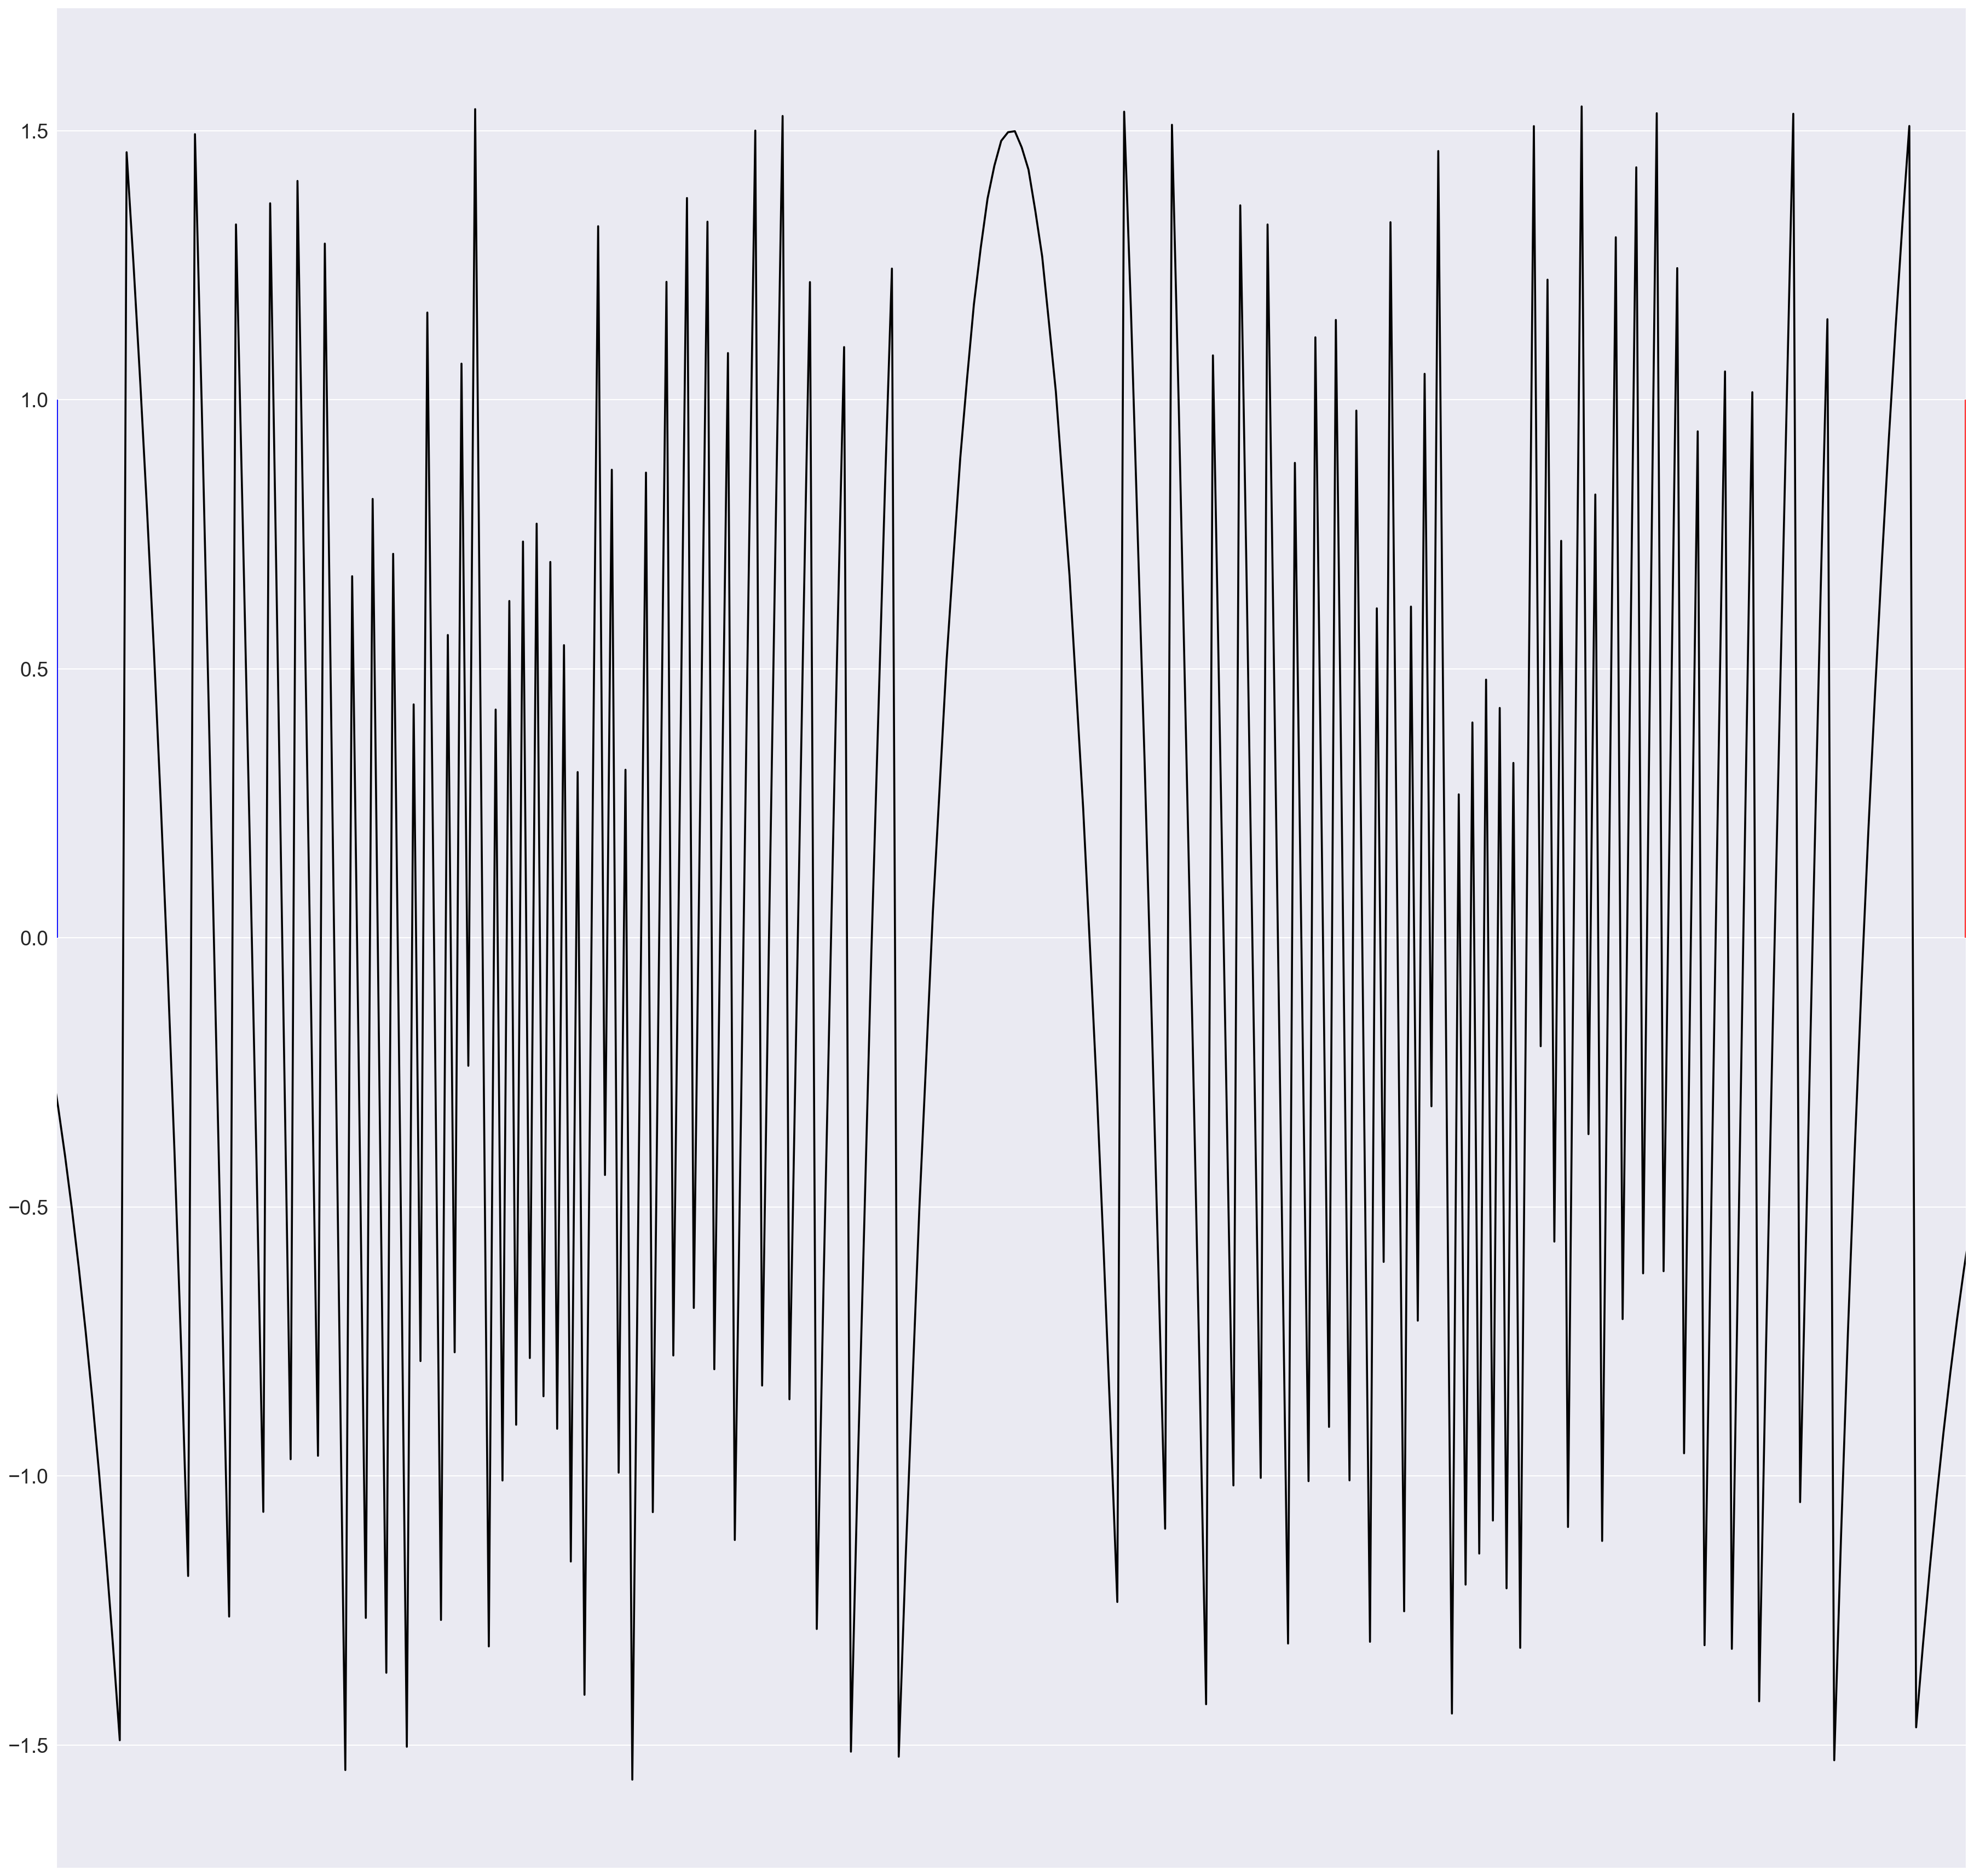

In [148]:

fig1=plt.figure(figsize=(30,30),dpi=150)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.plot(xs,hfvac_angle,color='black')
plt.xlim(fmin,fmax)
lim1=[plt.axis()[2],plt.axis()[3]]
plt.vlines(fmin,0,1,colors='blue')
plt.vlines(fmax,0,1,colors='red')

plt.xscale('log')
#plt.yscale('log')
plt.show()

In [171]:
'''spa test for gas'''

def f_to_r(f):
    return np.power(np.sqrt(10.0*m_sun)/sciconsts.pi/f,2.0/3.0)

r=[f_to_r(figas),f_to_r(ffgas)]
(r[0]+r[1])/2*(r[1]-r[0])/t_scale/2.0/np.sqrt(m_sun)

-4.8711252082352981e-09